In [1]:
import logging
logging.captureWarnings(False)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
from dask.distributed import Client, progress
client = Client(n_workers=5, threads_per_worker=4, memory_limit='100GB')
client

/Users/bkirtman/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 62111 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:62111/status,
Dashboard: http://127.0.0.1:62111/status,Workers: 5
Total threads: 20,Total memory: 465.66 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:62112,Workers: 5
Dashboard: http://127.0.0.1:62111/status,Total threads: 20
Started: Just now,Total memory: 465.66 GiB
Comm: tcp://127.0.0.1:62136,Total threads: 4
Dashboard: http://127.0.0.1:62140/status,Memory: 93.13 GiB
Nanny: tcp://127.0.0.1:62118,


In [2]:
import torch
import torch_harmonics.distributed as dist
import torch_harmonics as th
import xarray as xr
import numpy as np
import xesmf as xe
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from subs1_utils import precompute_latitudes, bscst

import warnings
warnings.filterwarnings("ignore")

cmap = 'turbo'

In [3]:
### Define Spectral Truncation Desired and Consistent
###    Gausian Grid
zw = 63
mw = 63
jmax = 96
imax = 192
###
###
###
###
# Setup necessary element for interpolation onto model Gaussian Grid
# Get the Gaussian latitudes on equally spaced longitudes (xr.dataset)
cost_lg, wlg, lats = precompute_latitudes(jmax)
lats = 90-180*lats/(np.pi)
lons = np.linspace(0.0,360.0-360.0/imax,imax)
dlatlon = xr.Dataset({"lat": lats, "lon": lons})

# Instantiate  grid to spectral (dsht) and spectral to grid (disht) transforms
#
vsht = th.RealVectorSHT(jmax, imax, lmax=mw, mmax=zw, grid="legendre-gauss", csphase=False)
dsht = dist.DistributedRealSHT(jmax, imax, lmax=mw, mmax=zw, grid="legendre-gauss", csphase=False)
disht = dist.DistributedInverseRealSHT(jmax, imax, lmax=mw, mmax=zw, grid="legendre-gauss", csphase=False)
dvsht = dist.DistributedRealVectorSHT(jmax, imax, lmax=mw, mmax=zw, grid="legendre-gauss", csphase=False)
divsht = dist.DistributedInverseRealVectorSHT(jmax, imax, lmax=mw, mmax=zw, grid="legendre-gauss", csphase=False)

In [4]:
### Grab Topography Data
###
url_topo = 'http://research.jisao.washington.edu/data_sets/elevation/elev.0.75-deg.nc'
ds_topo = xr.open_dataset(url_topo + '#mode=bytes', decode_times = False) # adding #mode=bytes because netcdf4 non-opendap URLrequeriment
del ds_topo['time']
data = ds_topo.data.squeeze()
data

<xarray.DataArray 'data' (lat: 241, lon: 480)>
[115680 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 90.0 89.25 88.5 87.75 ... -87.75 -88.5 -89.25 -90.0
  * lon      (lon) float32 0.0 0.75 1.5 2.25 3.0 ... 357.0 357.8 358.5 359.2
Attributes:
    units:      m
    long_name:  m

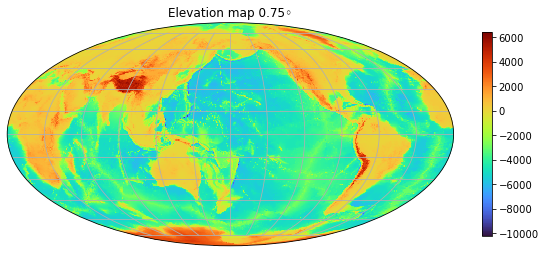

In [5]:
lon = np.linspace(-np.pi, np.pi, data.shape[1])
lat = np.linspace(np.pi/2., -np.pi/2., data.shape[0])
Lon, Lat = np.meshgrid(lon, lat)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection='mollweide')
cs = ax.pcolormesh(Lon, Lat, data, cmap=cmap)
ax.set_title("Elevation map 0.75◦")
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])
fig.colorbar(cs, ax=ax, shrink=0.75)
plt.show()

In [6]:
regridder_topog = xe.Regridder(data, dlatlon,'bilinear')

In [7]:
topog_gg = regridder_topog(data)*9.8

In [8]:
topog_gg_dev = torch.from_numpy(np.where(topog_gg < 0.0, 0.0, topog_gg))
coeffs = dsht(topog_gg_dev)
topog_gg_r = disht(coeffs)

In [9]:
# Write out the spectral coefficients for topography to be read by
# the AGCM as a pickle file
#
torch.save(coeffs,'topog.spectral.pt')

In [10]:
#
#
# Surface temp used to derive 3-D temperature field for
# Newtonian Relaxation
#
#
ftemp = 'http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/Monthlies/surface/air.sig995.mon.mean.nc'
Dtemp = xr.open_dataset(ftemp,autoclose=True)
Dtemp
#
# Field above is monthly 0.995 sigma level data
# 

<xarray.Dataset>
Dimensions:  (lon: 144, time: 913, lat: 73)
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2024-01-01
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    description:                     Data from NCEP initialized reanalysis (4...
    platform:                        Model
    Conventions:                     COARDS
    NCO:                             20121012
    history:                         Thu May  4 20:11:16 2000: ncrcat -d time...
    title:                           monthly mean air.sig995 from the NCEP Re...
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.2,hdf5=1.8.20
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimension:  time

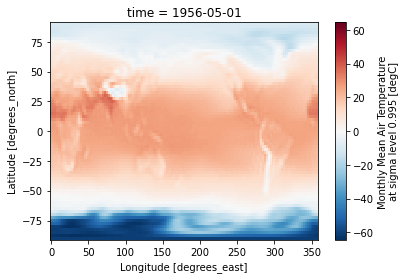

In [11]:
Dtemp.air[100,:,:].plot()

In [12]:
#
# Need to set up vertical structure of back-ground temp based on
# first sigma level in put. Will need model vertical structure
# from subs1_utils
#
# First Calculate Climatology
#
tsurf_climo = Dtemp.air.groupby('time.month').mean(dim='time')
#

In [13]:
# Then interpolate to Gaussian grid
#
regridder_temp = xe.Regridder(tsurf_climo[1,:,:],dlatlon,'bilinear')
#
tsurf_feb = regridder_temp(tsurf_climo[1,:,:])
#

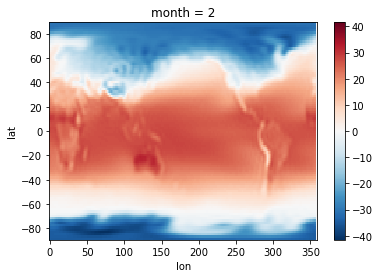

In [14]:
tsurf_feb.plot()

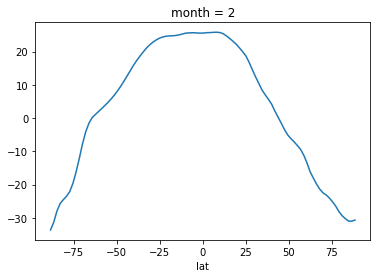

In [15]:
tsurf_feb_zonalmean = tsurf_feb.mean(dim='lon')
tsurf_feb_zonalmean.plot()

In [17]:
#
# Now generature the vertical strucuture of temperature
# will neeed model vertical structure (si(kmax))
#
from subs1_utils import *
#
kmax = 26
delsig, si, sl, sikap, slkap, cth1, cth2, r1b, r2b = bscst(kmax)
#
#
temp_spec = torch.from_numpy(np.zeros((kmax,zw,mw)))
temp_gg = np.zeros((kmax,jmax,imax))
#
#   Radiative equilibrium temperature
#       varying surface temperature decreasing with
#       height with a lapse rate dTe/dz approx = -rlaps degrees/m
#       to a stratospheric temperature of tstrat
#
rlaps=6.8*1.0e-03
h0 = 8.2e+03
tstrat = 205.0 # fixed stratospheric temperature
#
#for ii in range(n_lamda):
#    temp_gg[kmax-1,:,ii] = tsurf_feb_zonalmean[:].values + 273.16 # Uncomment if
                                                        # only using zonal mean surface
                                                        # temperature
temp_gg[kmax-1,:,:] = tsurf_feb.values + 273.16 # Uncomment if using full surface 
                                                 # temperature
for k in np.arange(1, kmax, 1, dtype=int):
    temp_gg[k,:,:] = temp_gg[kmax-1,:,:] + h0*rlaps*np.log(sl[k])
#
temp_gg[:,:,imax-1] = temp_gg[:,:,0]
temp_gg = np.where(temp_gg < 205.0, 205.0, temp_gg)

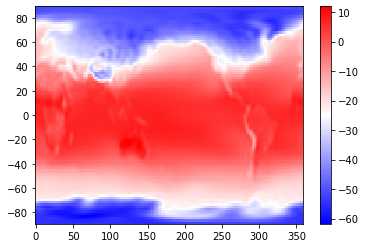

In [19]:
Lon, Lat = np.meshgrid(lons, lats)
plt.pcolormesh(Lon, Lat, temp_gg[20,:,:]-273.16, cmap='bwr')
plt.colorbar()

In [20]:
temp_coeffs = dsht(torch.from_numpy(temp_gg))

In [21]:
torch.save(temp_coeffs,'temp.spectral.pt')

In [22]:
#
ftemp = 'http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/Monthlies/surface_gauss/pres.sfc.mon.mean.nc'
Dps = xr.open_dataset(ftemp,autoclose=True)
Dps

<xarray.Dataset>
Dimensions:  (lon: 192, lat: 94, time: 913)
Coordinates:
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float32 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2024-01-01
Data variables:
    pres     (time, lat, lon) float32 ...
Attributes:
    Conventions:                     COARDS
    description:                     Data is from NCEP initialized reanalysis...
    platform:                        Model
    NCO:                             20121013
    history:                         Created 2011/06/28 by ESRL/PSD Web & Dat...
    title:                           monthly mean pres.sfc from the NCEP Rean...
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.2,hdf5=1.8.20
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimension:  time

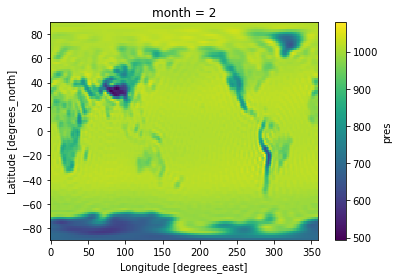

In [23]:
psmean = Dps.pres.groupby('time.month').mean(dim='time')
(psmean[1]/100).plot()

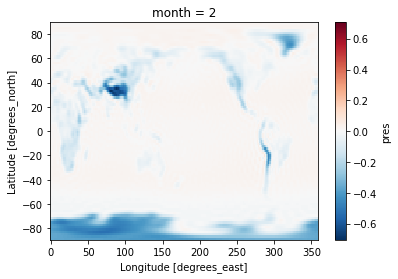

In [24]:
lnps = np.log(psmean[1]/(1000*100))
lnps.plot()

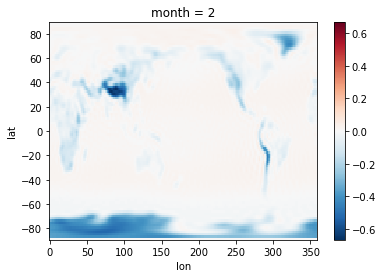

In [25]:
# Then interpolate to Gaussian grid
#
regridder_lnps = xe.Regridder(lnps,dlatlon,'bilinear')
#
lnps_feb = regridder_lnps(lnps)
lnps_feb[:,imax-1] = lnps_feb[:,imax-2]
lnps_feb.plot()
#

In [26]:
lnps_coeffs = dsht(torch.from_numpy(lnps_feb.values))
torch.save(lnps_coeffs,'lnps.spectral.pt')

In [27]:
#
# possible prescribed heating
#
ftemp = 'http://psl.noaa.gov/thredds/dodsC/Datasets/cmap/enh/precip.mon.mean.nc'
Dprec = xr.open_dataset(ftemp,autoclose=True)
Dprec

<xarray.Dataset>
Dimensions:  (lat: 72, lon: 144, time: 541)
Coordinates:
  * lat      (lat) float32 88.75 86.25 83.75 81.25 ... -83.75 -86.25 -88.75
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2024-01-01
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes: (12/13)
    Conventions:                     COARDS
    title:                           CPC Merged Analysis of Precipitation (in...
    platform:                        Analyses
    source:                          ftp ftp.cpc.ncep.noaa.gov precip/cmap/mo...
    dataset_title:                   CPC Merged Analysis of Precipitation
    documentation:                   https://www.esrl.noaa.gov/psd/data/gridd...
    ...                              ...
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    version:                         V2402
    history:                         update 02/2024 V2402
    data_modified:                   2024-02-12
    DODS_EXTRA.Unlimited_Dimension:  time

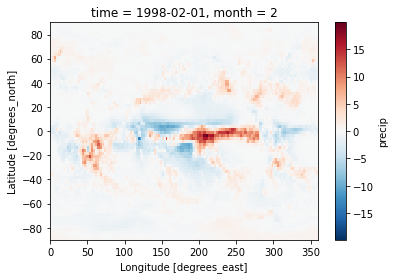

In [28]:
#
prec_clim = Dprec.precip.groupby('time.month').mean(dim='time')
prec_anom = Dprec.precip.groupby('time.month') - prec_clim
#
# ENSO Warm years
wyrs = ['1983','1987','1988','1992','1995','1998','2003','2005','2007','2010','2015','2016','2019']
wyrs = ['1998','1998','1998','1998','1998','1998','1998','1998','1998','1998','1998','1998','1998']
anom = prec_anom[0]*0.0
for k in range(13):
    #anom = anom + prec_anom.sel(time=slice(wyrs[k]+'-01-01',wyrs[k]+'-03-01')).mean(dim='time')
    anom = anom + prec_anom.sel(time=wyrs[k]+'-02-01')
rain_anom = anom/13.0
rain_anom.plot()

In [29]:
#
# Convert rainfall anomaly into a hearting rate that can
# applied to the temperature equation (i.e., Q/Cp) and distribute
# in the vertical
#
vert_struc = np.zeros(kmax) # whatever user wants
#                                 kmax is lowest level and
#                                 0 is the upper most level of
#                                 the atmosphere
heat = torch.zeros((kmax,jmax,imax),dtype=torch.float64)
#
if (kmax == 11):
    vert_struc[0] = 0.0
    vert_struc[1] = 0.1
    vert_struc[2] = 0.2
    vert_struc[3] = 1.5
    vert_struc[4] = 1.9
    vert_struc[5] = 1.5
    vert_struc[6] = 0.9
    vert_struc[7] = 0.5
    vert_struc[8] = 0.2
    vert_struc[9] = 0.1
    vert_struc[10] = 0.0
#
if (kmax == 26):
    vert_struc[0] = 0.0
    vert_struc[1] = 0.0
    vert_struc[2] = 0.0
    vert_struc[3] = 0.0
    vert_struc[4] = 0.0
    vert_struc[5] = 0.25
    vert_struc[6] = 0.5
    vert_struc[7] = 0.75
    vert_struc[8] = 1.0
    vert_struc[9] = 1.5
    vert_struc[10] = 1.75
    vert_struc[11] = 1.75
    vert_struc[12] = 1.75
    vert_struc[13] = 2.0
    vert_struc[14] = 2.0
    vert_struc[15] = 2.0
    vert_struc[16] = 2.0
    vert_struc[17] = 1.75
    vert_struc[18] = 1.75
    vert_struc[19] = 1.5
    vert_struc[20] = 1.25
    vert_struc[21] = 0.75
    vert_struc[22] = 0.5
    vert_struc[23] = 0.25
    vert_struc[24] = 0.0
    vert_struc[25] = 0.0
#
# Need to ensure that vertical integral normalizes to 1.0
rnorm = (vert_struc*delsig).sum()
vert_struc = vert_struc/rnorm
#
# interpolate to Gaussian grid
#
regridder_oi2 = xe.Regridder(rain_anom,dlatlon,'bilinear')
#
tmp = regridder_oi2(rain_anom)
tmp = np.where(tmp < 0.0, 0.0, tmp)
#
dheat = xr.Dataset({'heat': (['lat','lon'],tmp)}, 
                        coords={'lat': lats, 'lon': lons})
globz = dheat.heat.mean(dim='lon')
globm = globz.mean(dim='lat')
tmp = (dheat.heat - globm).values
tmp_hold = tmp
#
#
# convert to heating and multiple by vertical structure
#
Lv = 2.5e+06
rhow = 1000.0
Cp = 1005.0
Ps = 101325.0
grav = 9.8
beta = (Lv*rhow/Cp)*(grav/Ps)/(1000.0*86400.0)
tropics = np.exp((-Lat*Lat)/1000.0) # limit forcing to tropics
tmp = tropics*tmp
#
# Transform forward and backward to reduce forcing at unresolved scales
#
tmpspec = dsht(torch.from_numpy(tmp))
tmp = disht(tmpspec)
#
for k in range(kmax):
    heat[k,:,:] = (tmp[:,:]*vert_struc[k]*beta) # in K/sec

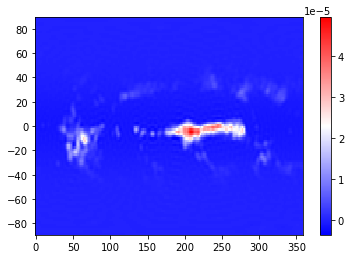

In [30]:
#
Lon, Lat = np.meshgrid(lons, lats)
plt.pcolormesh(Lon, Lat, heat[20], cmap='bwr')
plt.colorbar()

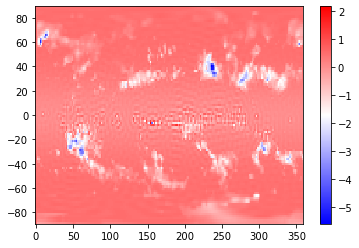

In [31]:
#
Lon, Lat = np.meshgrid(lons, lats)
plt.pcolormesh(Lon, Lat, tmp-tmp_hold, cmap='bwr')
plt.colorbar()

In [32]:
#
torch.save(heat,'heat.ggrid.pt') # South-to-North same as topog data
#

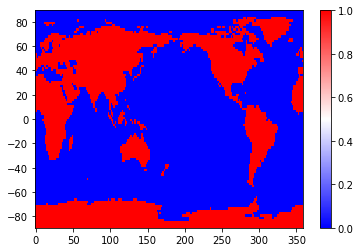

In [33]:
Lon, Lat = np.meshgrid(lons, lats)
landsea = np.where(topog_gg <= 0.0, 0.0,1.0)
plt.pcolormesh(Lon, Lat, landsea, cmap='bwr')
plt.colorbar()

In [34]:
#
torch.save(landsea,'landsea.ggrid.pt') 
#

In [35]:
#
# The remaining cells only need to be executed if prescribed background
# state is being used

In [36]:
def press_to_sig(kmax,imax,jmax,press_data,press_levels,ps,slmodel,kmax_model):
    # 
    # first convert pressure data to sigma using ps
    #
    sig_levels = torch.zeros((kmax,jmax,imax),dtype=torch.float64) # sigma levels of input data
    sig_data = torch.zeros((kmax_model,jmax,imax),dtype=torch.float64) # output on model sigma levels
    slmap = torch.zeros((kmax_model,jmax,imax),dtype=torch.float64) # model sigma levels but for all j & i
    for k in range(kmax):
        sig_levels[k,:,:] = press_levels[k]/ps[:,:] # sig_levels depends on k,j & i
    for k in range(kmax_model):
        slmap[k,:,:] = torch.tensor(slmodel[k]) 
    #
    # now at each j & i to interpolate to the appropriate model sigma level
    # Use log(sig) for interpolation
    #
    for isig in range(kmax_model):
        for ipress in np.arange(kmax-1, -1, -1, dtype=int):
            foo_up = torch.gt(slmap[isig],sig_levels[ipress-1])
            foo_dn = torch.lt(slmap[isig],sig_levels[ipress])
            # test if appropriate press level found
            foo_up = 1*foo_up
            foo_dn = 1*foo_dn
            foo = foo_up + foo_dn
            found = ( foo == 2 )
            found = 1*found
            ### found = 1 level found ; found = 0 level not found
            denom = torch.log(sig_levels[ipress])\
                            - torch.log(sig_levels[ipress-1])
            numer1 = torch.log(sig_levels[ipress])\
                            - torch.log(slmap[isig])
            numer2 = torch.log(slmap[isig])\
                            - torch.log(sig_levels[ipress-1])
            foo = numer1*press_data[ipress-1]/denom + numer2*press_data[ipress]/denom
            sig_data[isig] = found*(foo) + (1-found)*sig_data[isig]
    #
    #
    # Need to check if model sigma level is below reanalysis lowest sigma level
    #
    for isig in range(kmax_model):
        foo_dn = torch.gt(slmap[isig],sig_levels[kmax-1])
        foo_dn = 1*foo_dn
        sig_data[isig] = foo_dn*press_data[kmax-1] + (1-foo_dn)*sig_data[isig]
    #
    #
    #
    # Need to check if model sigma level is above reanalysis highest sigma level
    #
    for isig in range(kmax_model):
        foo_up = torch.lt(slmap[isig],sig_levels[0])
        foo_up = 1*foo_up
        sig_data[isig] = foo_up*press_data[0] + (1-foo_up)*sig_data[isig]
    #
    return sig_data

In [37]:
#
# The remaining cells only need to be executed if prescribed background
# state is being used
#
ftemp = 'http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/Monthlies/pressure/vwnd.mon.mean.nc'
Dvwnd = xr.open_dataset(ftemp,autoclose=True)
ftemp = 'http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/Monthlies/pressure/uwnd.mon.mean.nc'
Duwnd = xr.open_dataset(ftemp,autoclose=True)
ftemp = 'http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/Monthlies/pressure/air.mon.mean.nc'
Dair = xr.open_dataset(ftemp,autoclose=True)
uwnd_clim = Duwnd.uwnd.groupby('time.month').mean(dim='time')
vwnd_clim = Dvwnd.vwnd.groupby('time.month').mean(dim='time')
air_clim = Dair.air.groupby('time.month').mean(dim='time')
obs_levels = np.flipud(Dair['level'].values)
kobs = np.size(obs_levels)
#
# Interpolate u & v to Gaussian Grid
#
lnps_feb = disht(lnps_coeffs) # inverse tranform applied here to limit
                             # unresolved scales
ps_feb = (torch.exp(lnps_feb)*1000.0) # surface pressure in mb on Gaussian grid
#
#
regridder_oi2 = xe.Regridder(Duwnd.uwnd,dlatlon,'bilinear')
upress_gg = torch.zeros((kobs,jmax,imax),dtype=torch.float64)
vpress_gg = torch.zeros((kobs,jmax,imax),dtype=torch.float64)
airpress_gg = torch.zeros((kobs,jmax,imax),dtype=torch.float64)
for k in range(kobs):
    upress_gg[kobs-k-1] = torch.from_numpy((regridder_oi2(uwnd_clim[1,k])).values)
    upress_gg[kobs-k-1,:,imax-2] = upress_gg[kobs-k-1,:,imax-3]
    upress_gg[kobs-k-1,:,imax-1] = upress_gg[kobs-k-1,:,imax-2]
    upress_gg[kobs-k-1,:,0] = upress_gg[kobs-k-1,:,1]
    vpress_gg[kobs-k-1] = torch.from_numpy((regridder_oi2(vwnd_clim[1,k])).values)
    vpress_gg[kobs-k-1,:,imax-2] = vpress_gg[kobs-k-1,:,imax-3]
    vpress_gg[kobs-k-1,:,imax-1] = vpress_gg[kobs-k-1,:,imax-2]
    vpress_gg[kobs-k-1,:,0] = vpress_gg[kobs-k-1,:,1]
    airpress_gg[kobs-k-1] = torch.from_numpy((regridder_oi2(air_clim[1,k])).values) + 273.16
    airpress_gg[kobs-k-1,:,imax-2] = airpress_gg[kobs-k-1,:,imax-3]
    airpress_gg[kobs-k-1,:,imax-1] = airpress_gg[kobs-k-1,:,imax-2]
    airpress_gg[kobs-k-1,:,0] = airpress_gg[kobs-k-1,:,1]
#
#
# Interpolate from Pressure to Sigma Levels
#
usig_gg = press_to_sig(kobs,imax,jmax,upress_gg,obs_levels,ps_feb,sl,kmax)
vsig_gg = press_to_sig(kobs,imax,jmax,vpress_gg,obs_levels,ps_feb,sl,kmax)
tsig_gg = press_to_sig(kobs,imax,jmax,airpress_gg,obs_levels,ps_feb,sl,kmax)
tsig_gg = torch.where(tsig_gg < 205.0, 205.0, tsig_gg) ### This probably can be removed
                                                    ### with improved vertical resolution
#
#
# Need to apply forward and backward spectral transform to ensure that
# there is no unresolved forcing from the prescribed background state
#
tmpspec = dsht(usig_gg)
usig_gg = disht(tmpspec)
tmpspec = dsht(vsig_gg)
vsig_gg = disht(tmpspec)
tmpspec = dsht(tsig_gg)
tsig_gg = disht(tmpspec)
#
# convert u & v into spectral vort & divergence
#
zmn,dmn = vortdivspec(vsht,usig_gg,vsig_gg,kmax,mw,zw)
#
# Transform Spectral Vorticity and Divergence to Gaussian Grid
#
vortsig_gg = disht(zmn) ### This is relative vorticity
divsig_gg = disht(dmn)
#
qmn = lnps_coeffs
dxq_gg,dyq_gg = gradq(divsht,qmn,mw,zw,imax,jmax)
#
#
# Now write climo data
#
torch.save(usig_gg,'usig.ggrid.pt')
torch.save(vsig_gg,'vsig.ggrid.pt')
torch.save(tsig_gg,'tsig.ggrid.pt')
torch.save(vortsig_gg,'vortsig.ggrid.pt')
torch.save(divsig_gg,'divsig.ggrid.pt')
torch.save(dxq_gg,'dxq_gg.ggrid.pt')
torch.save(dyq_gg,'dyq_gg.ggrid.pt')
#
#

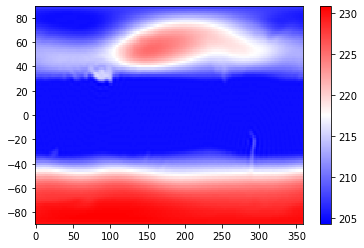

In [38]:
#
Lon, Lat = np.meshgrid(lons, lats)
plt.pcolormesh(Lon, Lat, tsig_gg[6], cmap='bwr')
plt.colorbar()

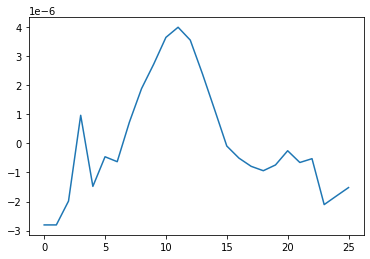

In [41]:
plt.plot(divsig_gg[:,50,70])

In [42]:
temp_gg = disht(temp_coeffs)

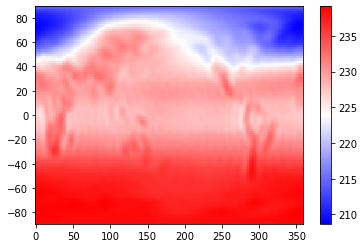

In [43]:
#
Lon, Lat = np.meshgrid(lons, lats)
footemp = tsig_gg - temp_gg
plt.pcolormesh(Lon, Lat, tsig_gg[0], cmap='bwr')
plt.colorbar()

In [44]:
Dair

<xarray.Dataset>
Dimensions:  (level: 17, lon: 144, time: 913, lat: 73)
Coordinates:
  * level    (level) float32 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2024-01-01
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
Data variables:
    air      (time, level, lat, lon) float32 ...
Attributes:
    description:                      Data from NCEP initialized reanalysis (...
    platform:                        Model
    Conventions:                     COARDS
    NCO:                             20121012
    history:                         Mon Jul  5 21:45:36 1999: ncrcat air.mon...
    title:                           monthly mean air from the NCEP Reanalysis
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.2,hdf5=1.8.20
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimension:  time

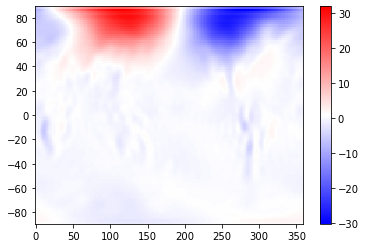

In [45]:
#
Lon, Lat = np.meshgrid(lons, lats)
footemp = tsig_gg - temp_gg
plt.pcolormesh(Lon, Lat, vsig_gg[0], cmap='bwr')
plt.colorbar()

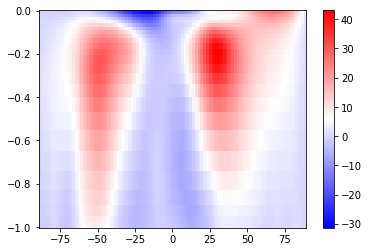

In [46]:
#
Lev,Lat = np.meshgrid(-sl,lats)
zonal_mean = usig_gg.mean(dim=2)
foofoo = torch.transpose(zonal_mean, 0, 1)
plt.pcolormesh(Lat, Lev, foofoo, cmap='bwr')
plt.colorbar()

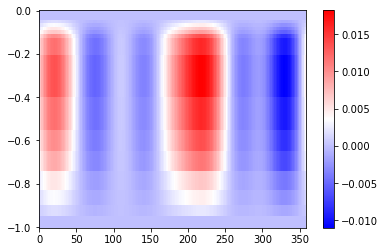

In [47]:
#
Lev,Lon = np.meshgrid(-sl,lons)
heating = heat[:,94,:]*86400
foofoo = torch.transpose(heating, 0, 1)
plt.pcolormesh(Lon, Lev, foofoo, cmap='bwr')
plt.colorbar()

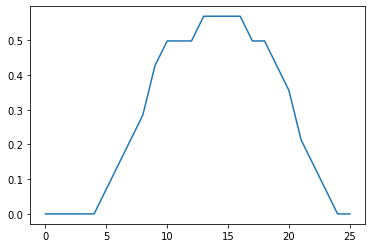

In [48]:
plt.plot(heat[:,33,70]*86400)

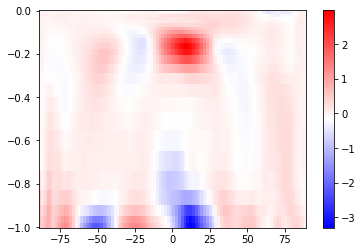

In [49]:
#
Lev,Lat = np.meshgrid(-sl,lats)
zonal_mean = vsig_gg.mean(dim=2)
foofoo = torch.transpose(zonal_mean, 0, 1)
plt.pcolormesh(Lat, Lev, foofoo, cmap='bwr')
plt.colorbar()

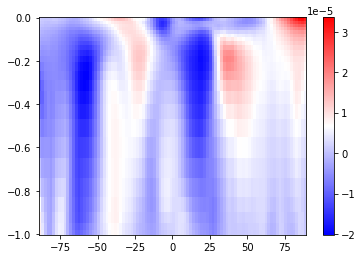

In [50]:
#
Lev,Lat = np.meshgrid(-sl,lats)
zonal_mean = vortsig_gg.mean(dim=2)
foofoo = torch.transpose(zonal_mean, 0, 1)
plt.pcolormesh(Lat, Lev, foofoo, cmap='bwr')
plt.colorbar()

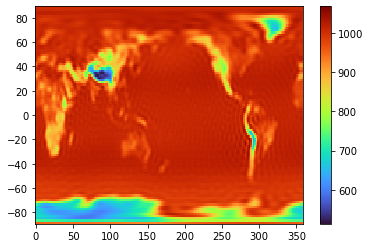

In [51]:
Lon, Lat = np.meshgrid(lons, lats)
plt.pcolormesh(Lon, Lat, ps_feb, cmap=cmap)
plt.colorbar()

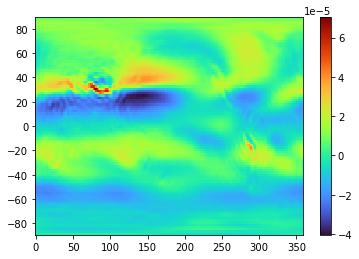

In [52]:
Lon, Lat = np.meshgrid(lons, lats)
plt.pcolormesh(Lon, Lat, vortsig_gg[10], cmap=cmap)
plt.colorbar()

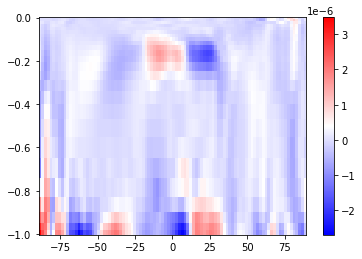

In [53]:
#
Lev,Lat = np.meshgrid(-sl,lats)
zonal_mean = divsig_gg.mean(dim=2)
foofoo = torch.transpose(zonal_mean, 0, 1)
plt.pcolormesh(Lat, Lev, foofoo, cmap='bwr')
plt.colorbar()